In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset, Dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation
from PIL import Image

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.preprocessing.bio_technique.make_dataset import *
from src.model.bio_technique.trainer import BioTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
!mkdir logs
model_name = "BioTechnique"
dataset_name = "SROIE"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Loading FUNSD Dataset

In [15]:
sroie_dataset = load_dataset("darentang/sroie",
                             cache_dir= "/Data/pedro.silva/")

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [7]:
n_classes = len(sroie_dataset['train'].features['ner_tags'].feature.names)
n_classes

9

In [8]:
l = sroie_dataset['train'].features['ner_tags'].feature.names

In [9]:
idx2label = {}
for k, v in enumerate(l):
    if v == 'O':
        idx2label[k] = "none"

    else:
        idx2label[k] = v.split('-')[1].lower() 

In [10]:
idx2label

{0: 'none',
 1: 'company',
 2: 'company',
 3: 'date',
 4: 'date',
 5: 'address',
 6: 'address',
 7: 'total',
 8: 'total'}

In [14]:
label_names = np.unique(list(idx2label.values()))
label_names

array(['address', 'company', 'date', 'none', 'total'], dtype='<U7')

In [ ]:
tokenizer.sep_token

'[SEP]'

## Training models

### 2 shots

In [16]:
train_data = generate_dataset(
    sroie_dataset['train'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=2,
)

val_data = generate_dataset(
    sroie_dataset['test'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=50,
)

test_data = generate_dataset(
    Dataset.from_dict(sroie_dataset['train'][10:]),
    label_names,
    idx2label,
    tokenizer,
    n_shots = np.inf,
)

In [17]:
train_dataset = ImageLayoutDataset(
    train_data,
    tokenizer    
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=False
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 95.37it/s]


In [22]:
validation_dataset = ImageLayoutDataset(
    val_data,
    tokenizer    
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle=False,
    batch_size= len(label_names)
)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:01<00:00, 179.17it/s]


In [21]:
test_dataset = ImageLayoutDataset(
    test_data,
    tokenizer    
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size= len(label_names)
)

100%|██████████| 3080/3080 [00:17<00:00, 178.44it/s]


In [28]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

trainer = BioTrainer(
    model,
    optimizer,
    len(label_names)
)

history = trainer.compile(
    train_dataloader, 
    validation_dataloader,
    n_epochs = 100
)

100%|██████████| 100/100 [05:48<00:00,  3.49s/it]

f1-score : 0.9224793314933777
tensor([[ 513,   10,   15,  204,    1],
        [  10,  181,    1,   58,    0],
        [   0,    0,    1,    1,    0],
        [  35,   18,   42, 4767,   52],
        [   1,    3,    5,    3,    0]], device='cuda:0')


In [29]:
best_f1, best_epoch = np.max(history), np.argmax(history)

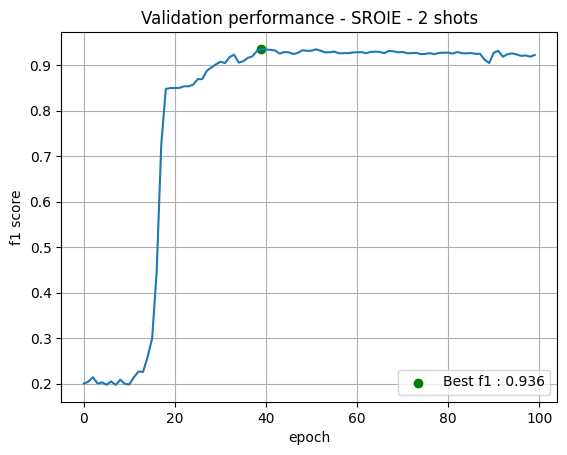

In [30]:
plt.plot(history)
plt.scatter(
    [best_epoch],
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.title(f"Validation performance - {dataset_name} - 2 shots")
plt.grid()

In [32]:
y_pred_val = torch.tensor([],device=device)
y_true_val = torch.tensor([],device=device)
for batch in tqdm(test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)

        if k == "bbox":
            continue
        batch[k] = batch[k].reshape(len(label_names),512)
    batch.pop('bbox')

    y_true = batch['labels']
    mask = y_true!= -100

    with torch.no_grad():
        y_pred = model(**batch).logits[:,:,1]
    y_pred = y_pred[mask]\
        .reshape(len(label_names),-1)[:,1:]\
        .argmax(dim = 0)

    y_true = y_true[mask]\
        .reshape(len(label_names),-1)[:, 1:]\
        .argmax(dim = 0)
    
    y_pred_val = torch.cat([y_pred, y_pred_val])
    y_true_val = torch.cat([y_true, y_true_val])

f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=len(label_names)
)

conf_matrix = multiclass_confusion_matrix(
    y_true_val.to(torch.int64),
    y_pred_val.to(torch.int64),
    num_classes= len(label_names)
)
print(f"f1-score : {f1.item()}")


logging.info(f"f1 score: {f1}")
logging.info(conf_matrix)

100%|██████████| 616/616 [00:35<00:00, 17.17it/s]


f1-score : 0.9251368045806885


In [33]:
label_names

array(['address', 'company', 'date', 'none', 'total'], dtype='<U7')

Text(0.5, 1.0, 'Performance - FUNSD - 2 shots')

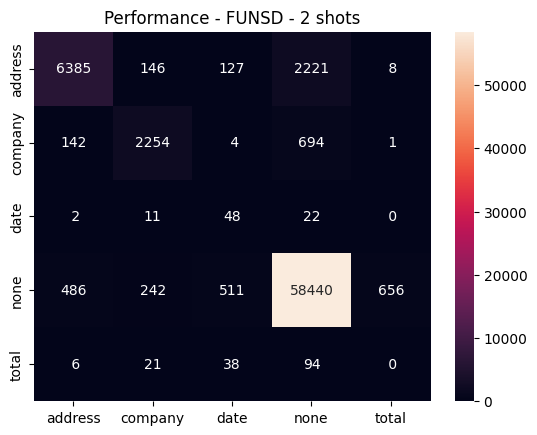

In [34]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 2 shots")


## 5 shots

In [35]:
n_shots = 5
train_data = generate_dataset(
    sroie_dataset['train'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=n_shots,
)

val_data = generate_dataset(
    sroie_dataset['test'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=50,
)

test_data = generate_dataset(
    Dataset.from_dict(sroie_dataset['train'][10:]),
    label_names,
    idx2label,
    tokenizer,
    n_shots = np.inf,
)

In [36]:
train_dataset = ImageLayoutDataset(
    train_data,
    tokenizer    
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=False
)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 167.45it/s]


In [37]:
validation_dataset = ImageLayoutDataset(
    val_data,
    tokenizer    
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle=False,
    batch_size= len(label_names)
)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:01<00:00, 172.24it/s]


In [38]:
test_dataset = ImageLayoutDataset(
    test_data,
    tokenizer    
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size= len(label_names)
)

  0%|          | 0/3080 [00:00<?, ?it/s]

100%|██████████| 3080/3080 [00:17<00:00, 176.16it/s]


In [39]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

trainer = BioTrainer(
    model,
    optimizer,
    len(label_names)
)

history = trainer.compile(
    train_dataloader, 
    validation_dataloader,
    n_epochs = 100
)

100%|██████████| 100/100 [07:03<00:00,  4.23s/it]

f1-score : 0.9542307257652283
tensor([[ 542,   13,   11,   80,    0],
        [   5,  189,    1,   64,    0],
        [   1,    0,   38,    5,    0],
        [  11,   10,   14, 4878,   50],
        [   0,    0,    0,    6,    3]], device='cuda:0')


In [40]:
best_f1, best_epoch = np.max(history), np.argmax(history)

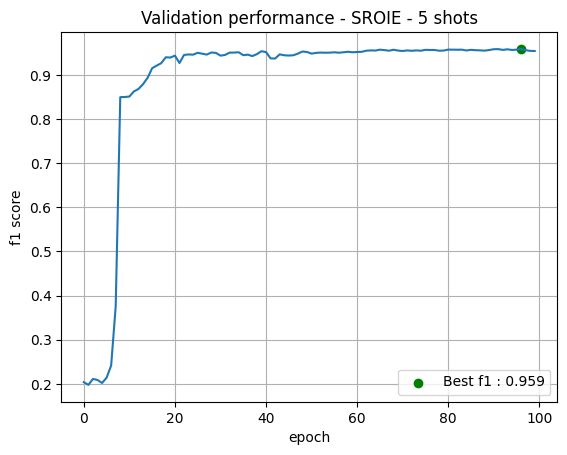

In [41]:
plt.plot(history)
plt.scatter(
    [best_epoch],
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.title(f"Validation performance - {dataset_name} - {n_shots} shots")
plt.grid()

In [45]:
y_pred_val = torch.tensor([],device=device)
y_true_val = torch.tensor([],device=device)
for batch in tqdm(test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)

        if k == "bbox":
            continue
        batch[k] = batch[k].reshape(len(label_names),512)
    batch.pop('bbox')

    y_true = batch['labels']
    mask = y_true!= -100

    with torch.no_grad():
        y_pred = model(**batch).logits[:,:,1]
    y_pred = y_pred[mask]\
        .reshape(len(label_names),-1)[:,1:]\
        .argmax(dim = 0)

    y_true = y_true[mask]\
        .reshape(len(label_names),-1)[:, 1:]\
        .argmax(dim = 0)
    
    y_pred_val = torch.cat([y_pred, y_pred_val])
    y_true_val = torch.cat([y_true, y_true_val])

f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=len(label_names)
)

conf_matrix = multiclass_confusion_matrix(
    y_true_val.to(torch.int64),
    y_pred_val.to(torch.int64),
    num_classes= len(label_names)
)
print(f"f1-score : {f1.item()}")


logging.info(f"f1 score: {f1}")
logging.info(conf_matrix)

100%|██████████| 616/616 [00:35<00:00, 17.36it/s]


f1-score : 0.9491448402404785


In [46]:
label_names

array(['address', 'company', 'date', 'none', 'total'], dtype='<U7')

Text(0.5, 1.0, 'Performance - FUNSD - 5 shots')

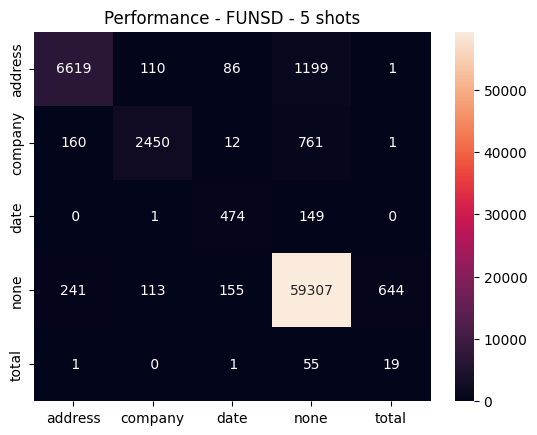

In [48]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Performance - FUNSD - {n_shots} shots")


## 10 shots

In [49]:
n_shots = 10
train_data = generate_dataset(
    sroie_dataset['train'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=n_shots,
)

val_data = generate_dataset(
    sroie_dataset['test'],
    label_names,
    idx2label,
    tokenizer,
    n_shots=50,
)

test_data = generate_dataset(
    Dataset.from_dict(sroie_dataset['train'][10:]),
    label_names,
    idx2label,
    tokenizer,
    n_shots = np.inf,
)

In [50]:
train_dataset = ImageLayoutDataset(
    train_data,
    tokenizer    
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=False
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 179.25it/s]


In [51]:
validation_dataset = ImageLayoutDataset(
    val_data,
    tokenizer    
)

validation_dataloader = DataLoader(
    validation_dataset,
    shuffle=False,
    batch_size= len(label_names)
)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:01<00:00, 181.08it/s]


In [52]:
test_dataset = ImageLayoutDataset(
    test_data,
    tokenizer    
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size= len(label_names)
)

  0%|          | 0/3080 [00:00<?, ?it/s]

100%|██████████| 3080/3080 [00:16<00:00, 182.51it/s]


In [53]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-uncased", num_labels = 2)
model.to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr = 1e-5
)

trainer = BioTrainer(
    model,
    optimizer,
    len(label_names)
)

history = trainer.compile(
    train_dataloader, 
    validation_dataloader,
    n_epochs = 100
)

100%|██████████| 100/100 [13:06<00:00,  7.87s/it]

f1-score : 0.9619996547698975
tensor([[ 519,    0,    2,   40,    0],
        [  12,  194,    2,   41,    0],
        [   0,    0,   35,    3,    0],
        [  28,   18,   23, 4948,   53],
        [   0,    0,    2,    1,    0]], device='cuda:0')


In [54]:
best_f1, best_epoch = np.max(history), np.argmax(history)

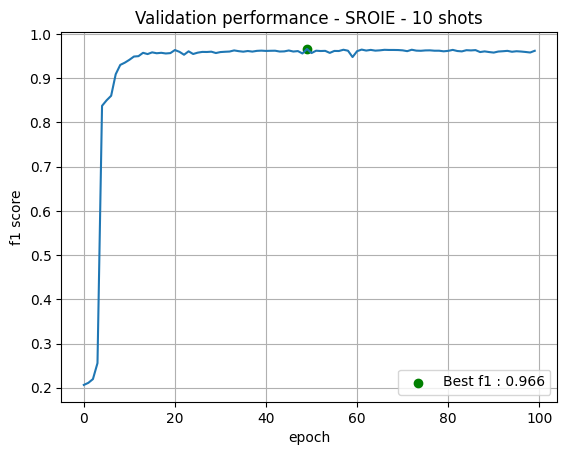

In [55]:
plt.plot(history)
plt.scatter(
    [best_epoch],
    [best_f1],
    color = "green",
    label = f"Best f1 : {round(best_f1,3)}"
)
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.title(f"Validation performance - {dataset_name} - {n_shots} shots")
plt.grid()

In [56]:
y_pred_val = torch.tensor([],device=device)
y_true_val = torch.tensor([],device=device)
for batch in tqdm(test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)

        if k == "bbox":
            continue
        batch[k] = batch[k].reshape(len(label_names),512)
    batch.pop('bbox')

    y_true = batch['labels']
    mask = y_true!= -100

    with torch.no_grad():
        y_pred = model(**batch).logits[:,:,1]
    y_pred = y_pred[mask]\
        .reshape(len(label_names),-1)[:,1:]\
        .argmax(dim = 0)

    y_true = y_true[mask]\
        .reshape(len(label_names),-1)[:, 1:]\
        .argmax(dim = 0)
    
    y_pred_val = torch.cat([y_pred, y_pred_val])
    y_true_val = torch.cat([y_true, y_true_val])

f1 = multiclass_f1_score(
    y_pred_val,
    y_true_val,
    num_classes=len(label_names)
)

conf_matrix = multiclass_confusion_matrix(
    y_true_val.to(torch.int64),
    y_pred_val.to(torch.int64),
    num_classes= len(label_names)
)
print(f"f1-score : {f1.item()}")


logging.info(f"f1 score: {f1}")
logging.info(conf_matrix)

  0%|          | 0/616 [00:00<?, ?it/s]

100%|██████████| 616/616 [01:03<00:00,  9.65it/s]


f1-score : 0.9512672424316406


In [57]:
label_names

array(['address', 'company', 'date', 'none', 'total'], dtype='<U7')

Text(0.5, 1.0, 'Performance - FUNSD - 10 shots')

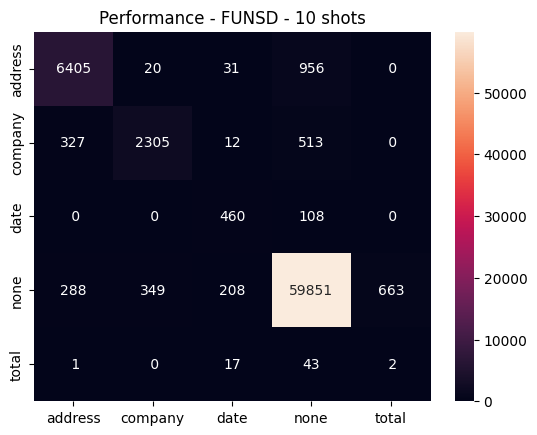

In [58]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Performance - FUNSD - {n_shots} shots")
